In [37]:
using Oceananigans
using Oceananigans.Units
using Oceananigans.OutputReaders: FieldTimeSeries
using CairoMakie 

In [ ]:
Lx = 100kilometers # north-south extent [m]
Lz = 1kilometers    # depth [m]

grid = RectilinearGrid(size = (48, 8),
                       x = (-Lx/2, Lx/2),
                       z = (-Lz, 0),
                       topology = (Bounded, Flat, Bounded))


               

0

In [56]:
# model parameters
N² = 1e-6  # [s⁻²] background stratification note: make them both 1e-6
M² = 1e-6  # [s⁻²] horizontal buoyancy gradient (front strength)
f = 1e-4
α = 0



0

In [39]:
# advective forcing term 
u_background = XFaceField(grid)
u_background .= -α * xnodes(grid, Face(), Center(), Center())
background_flow = AdvectiveForcing(u = u_background)

# no addtional u forcing

# v forcing
v_forcing_func(x, z, t, v, α) = - 2*α*v
v_forcing = Forcing(v_forcing_func, parameters = α, field_dependencies = :v )

# w forcing
w_forcing_func(x, z, t, w, α) = - α*w
w_forcing = Forcing(w_forcing_func, parameters = α, field_dependencies = :w )

# b forcing
b_forcing_func(x, z, t, α, b ) = - α*b
b_forcing = Forcing(b_forcing_func, parameters = α, field_dependencies= :b )



ContinuousForcing{Int64}
├── func: b_forcing_func (generic function with 1 method)
├── parameters: 0
└── field dependencies: (:b,)

In [40]:
damping_rate = 1/100

bottom_mask_3D = GaussianMask{:z}(center=-grid.Lz, width=grid.Lz/10)
bottom_mask(x,z) = bottom_mask_3D(x,0,z) #The mask function is in 3D so we have to adapt it to our 2D simulation, note 0 was chosen arbititarily.
uvw_sponge_bottom = Relaxation(rate=damping_rate, mask=bottom_mask)

left_mask_3D   = GaussianMask{:x}(center=-grid.Lx/2, width=grid.Lx/10)
left_mask(x,z) = left_mask_3D(x,0,z)
uvw_sponge_left = Relaxation(rate=damping_rate, mask=left_mask)

right_mask_3D  = GaussianMask{:x}(center=grid.Lx/2,  width=grid.Lx/10)
right_mask(x,z) = right_mask_3D(x,0,z)
uvw_sponge_right = Relaxation(rate=damping_rate, mask=right_mask)

uvw_sponge = ()
uvw_sponge_bottom, uvw_sponge_left, uvw_sponge_right


(Relaxation{Float64, typeof(bottom_mask), typeof(Oceananigans.Forcings.zerofunction)}
├── rate: 0.01
├── mask: bottom_mask (generic function with 1 method)
└── target: 0, Relaxation{Float64, typeof(left_mask), typeof(Oceananigans.Forcings.zerofunction)}
├── rate: 0.01
├── mask: left_mask (generic function with 1 method)
└── target: 0, Relaxation{Float64, typeof(right_mask), typeof(Oceananigans.Forcings.zerofunction)}
├── rate: 0.01
├── mask: right_mask (generic function with 1 method)
└── target: 0)

In [ ]:
model = NonhydrostaticModel(; grid,
                coriolis = FPlane(f = f),
                buoyancy = BuoyancyTracer(),
                tracers = :b,
                advection = WENO(),
                forcing = (; u = (background_flow, uvw_sponge_bottom, uvw_sponge_left, uvw_sponge_right),
                             v = (background_flow, v_forcing, uvw_sponge_bottom, uvw_sponge_left, uvw_sponge_right) , 
                             w = (background_flow, w_forcing, uvw_sponge_bottom, uvw_sponge_left, uvw_sponge_right),
                             b = (background_flow, b_forcing)
                #forcing = (; u = background_flow, v = (background_flow, v_forcing) , w = (background_flow, w_forcing), b = (background_flow, b_forcing)

                )
)
                


NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 48×1×8 RectilinearGrid{Float64, Bounded, Flat, Bounded} on CPU with 3×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: WENO{3, Float64, Float32}(order=5)
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
└── coriolis: FPlane{Float64}(f=0.0001)

In [42]:
#inital setup

Δx = 10kilometers  # initial front width
Δb = Δx * M²       # buoyancy jump across front
ϵb = 1e-2 * Δb     # noise amplitude

ramp(x, Δx) = min(max(0, x/Δx + 1/2), 1)
bᵢ(x, z) = N² * z + Δb * ramp(x, Δx) + ϵb * randn()

set!(model, b=bᵢ, u = 0, v = 0, w = 0)  # Start from rest


In [43]:
simulation = Simulation(model, Δt=20minutes, stop_time=20days)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 20 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 20 days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => 4
│   ├── stop_iteration_exceeded => -
│   ├── wall_time_limit_exceeded => e
│   └── nan_checker => }
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [44]:
conjure_time_step_wizard!(simulation, IterationInterval(20), cfl=0.2, max_Δt=20minutes)

In [45]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)
    u, v, w = model.velocities
    progress = 100 * (time(sim) / sim.stop_time)
    elapsed = (time_ns() - wall_clock[]) / 1e9

    @printf("[%05.2f%%] i: %d, t: %s, wall time: %s, max(u): (%6.3e, %6.3e, %6.3e) m/s, next Δt: %s\n",
            progress, iteration(sim), prettytime(sim), prettytime(elapsed),
            maximum(abs, u), maximum(abs, v), maximum(abs, w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    return nothing
end

add_callback!(simulation, print_progress, IterationInterval(100))

Diagnostic/Output

In [46]:
# Output setup
filename = "frontogenesis_2D"
u, v, w = model.velocities
ζ = ∂z(u) - ∂x(w)  # Vorticity in x-z plane
b = model.tracers.b

simulation.output_writers[:fields] = JLD2Writer(
    model, (; b, ζ , u, v, w),
    filename=filename * ".jld2",
    schedule=TimeInterval(0.5day),
    overwrite_existing=true 
) 

JLD2Writer scheduled on TimeInterval(12 hours):
├── filepath: frontogenesis_2D.jld2
├── 5 outputs: (b, ζ, u, v, w)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 41.4 KiB

In [47]:
@info "Running the simulation..."

run!(simulation)

@info "Simulation completed in " * prettytime(simulation.run_wall_time)

[ Info: Running the simulation...
[ Info: Initializing simulation...


[00.00%] i: 0, t: 0 seconds, wall time: 22.505 seconds, max(u): (0.000e+00, 0.000e+00, 0.000e+00) m/s, next Δt: 20 minutes


[ Info:     ... simulation initialization complete (14.392 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (3.392 seconds).


[00NaN%] i: 100, t: NaN days, wall time: 9.001 seconds, max(u): (   NaN,    NaN,    NaN) m/s, next Δt: NaN days


[ Info: time = NaN, iteration = 100: NaN found in field u. Stopping simulation.
[ Info: Simulation completed in 19.593 seconds


In [48]:
# Visualization
b_ts = FieldTimeSeries(filename * ".jld2", "b")
ζ_ts = FieldTimeSeries(filename * ".jld2", "ζ")

u_ts = FieldTimeSeries(filename * ".jld2", "u")
v_ts = FieldTimeSeries(filename * ".jld2", "v")
w_ts = FieldTimeSeries(filename * ".jld2", "w")

times = b_ts.times


StepRangeLen(0.0, 0.0, 1)

In [49]:
# Coordinates
x = xnodes(grid, Center())# ./ 1e2  # km
z = znodes(grid, Center())# ./ 1e2  # km

-937.5:125.0:-62.5

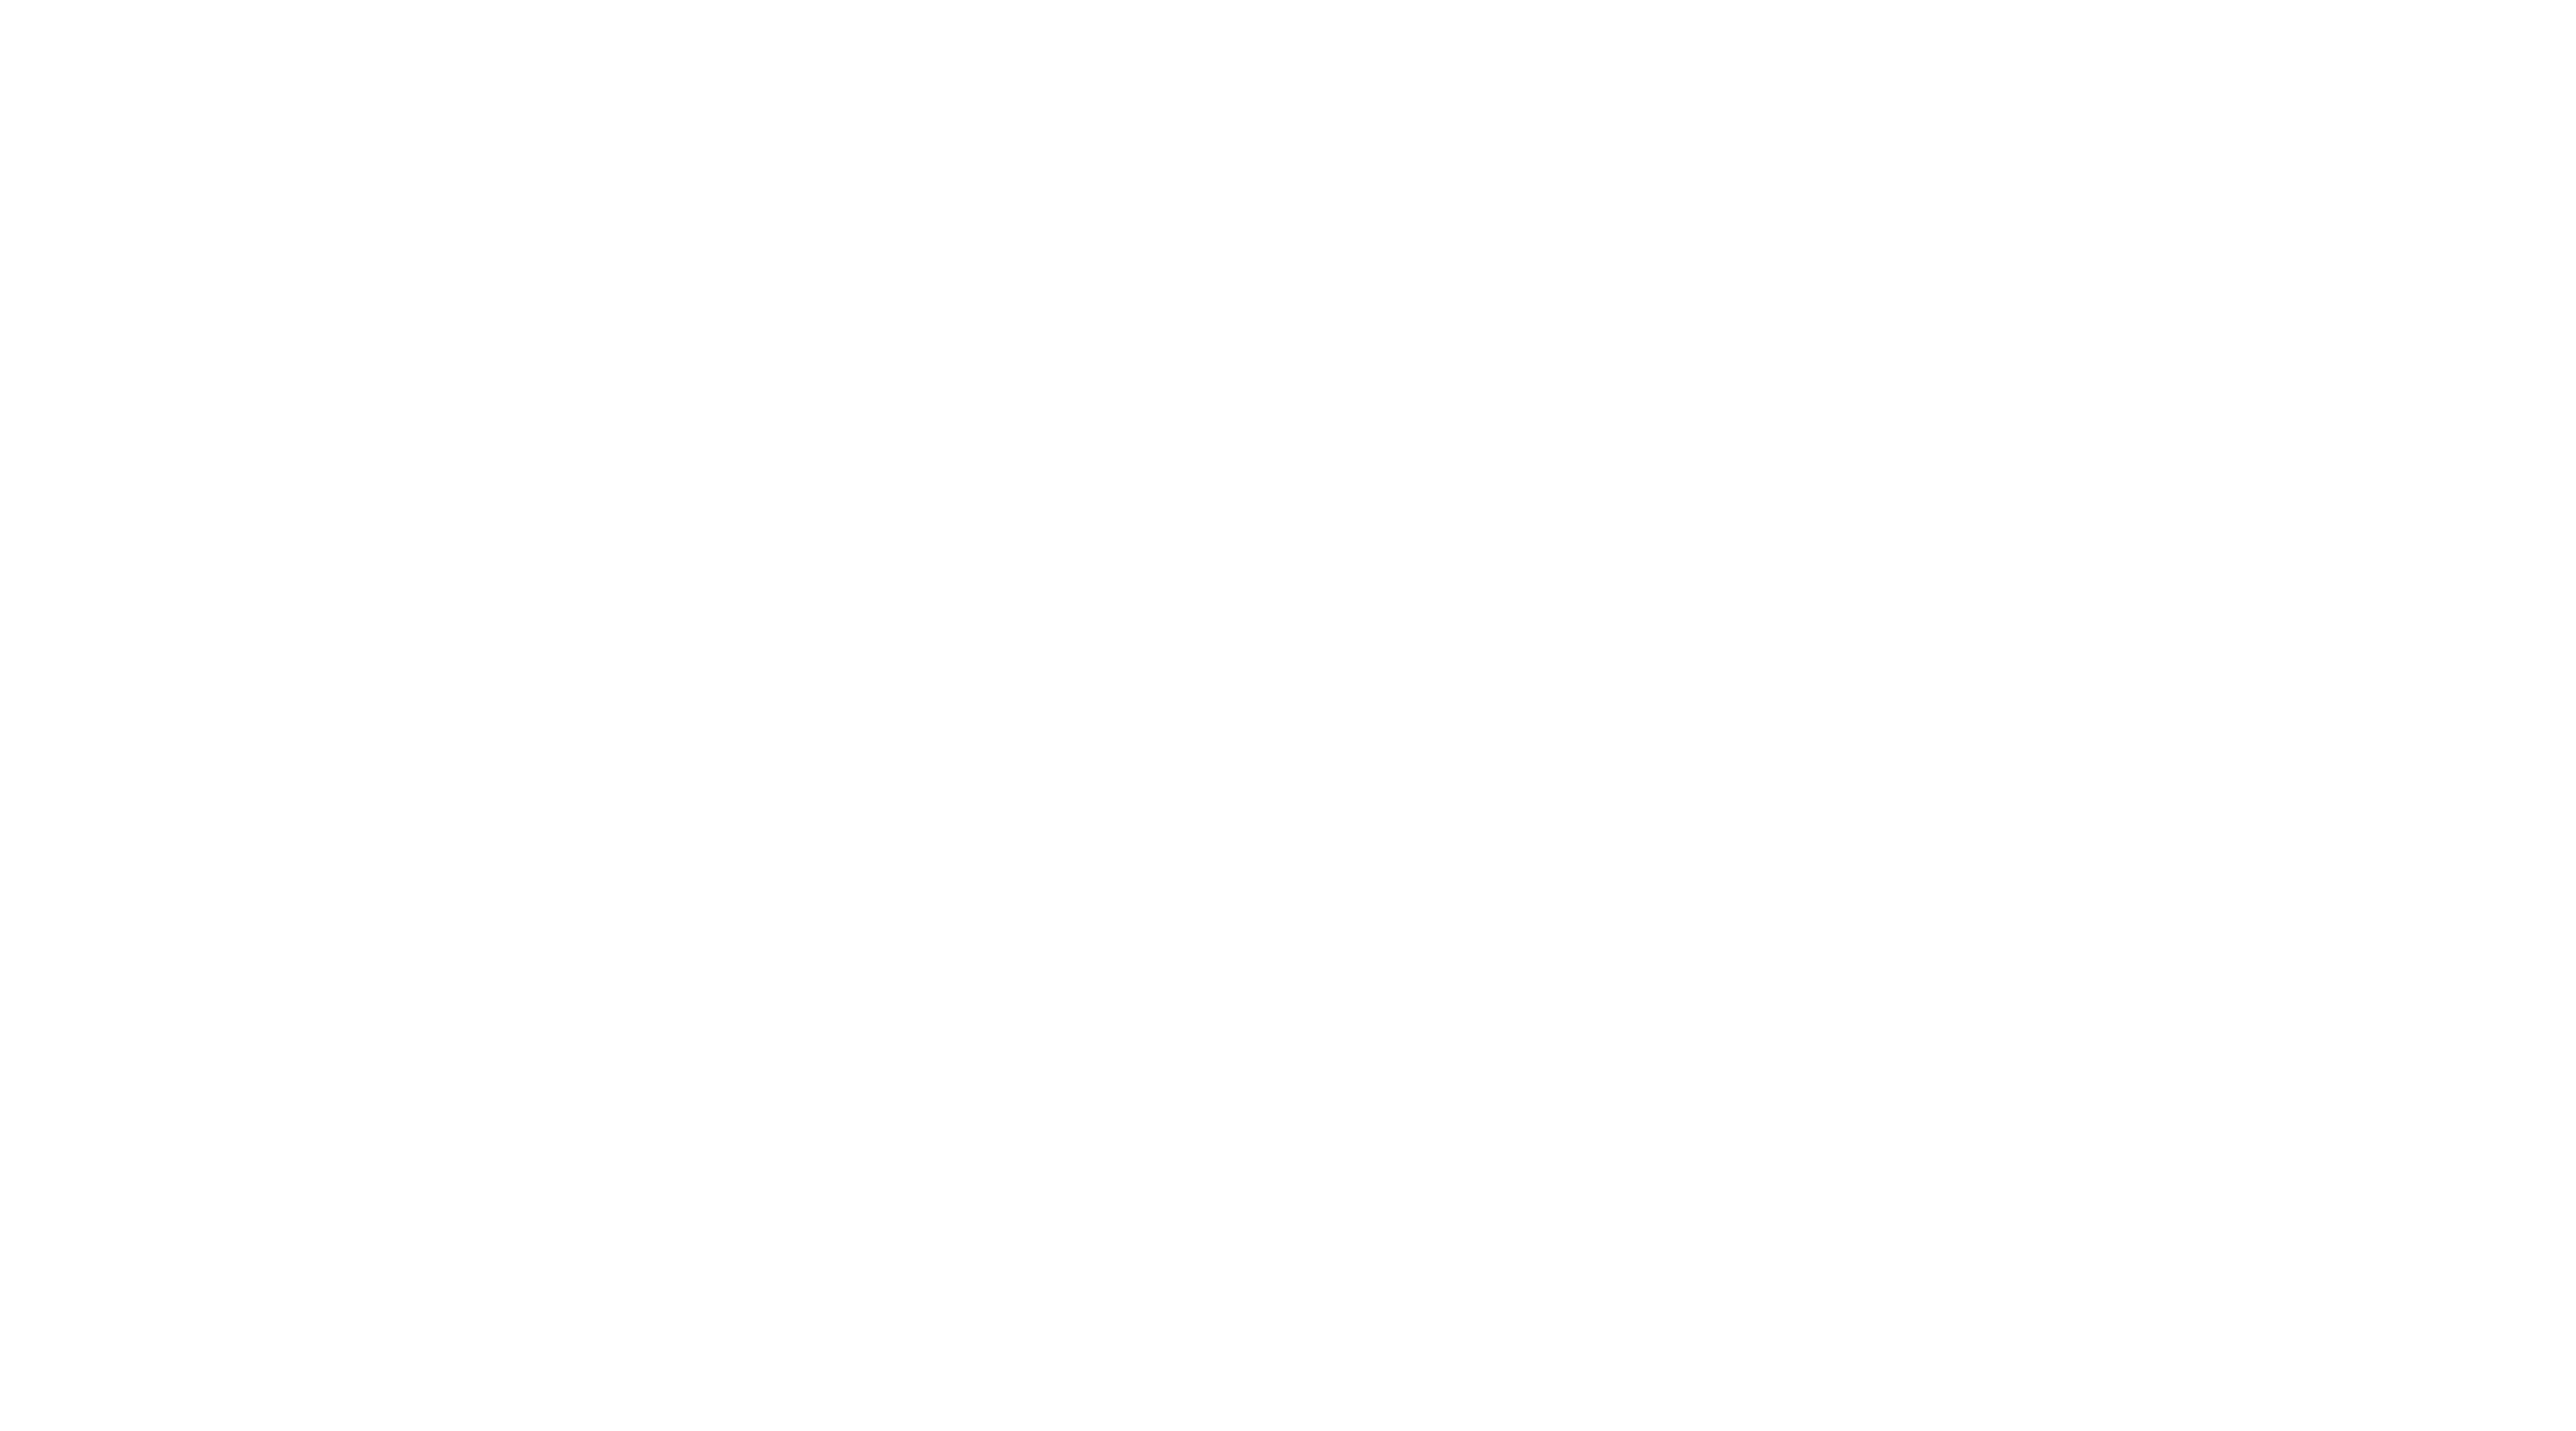

In [50]:
#using CairoMakie
fig = Figure(size=(1800, 1000))

In [51]:
# Animation setup
n = Observable(1)
b_slice = @lift interior(b_ts[$n], :, 1, :)
ζ_slice = @lift interior(ζ_ts[$n], :, 1, :)

u_slice = @lift interior(u_ts[$n], :, 1, :)
v_slice = @lift interior(v_ts[$n], :, 1, :)
w_slice = @lift interior(w_ts[$n], :, 1, :)

title_text = @lift "Day $(round(times[$n]/day, digits=1))"

Observable("Day 0.0")


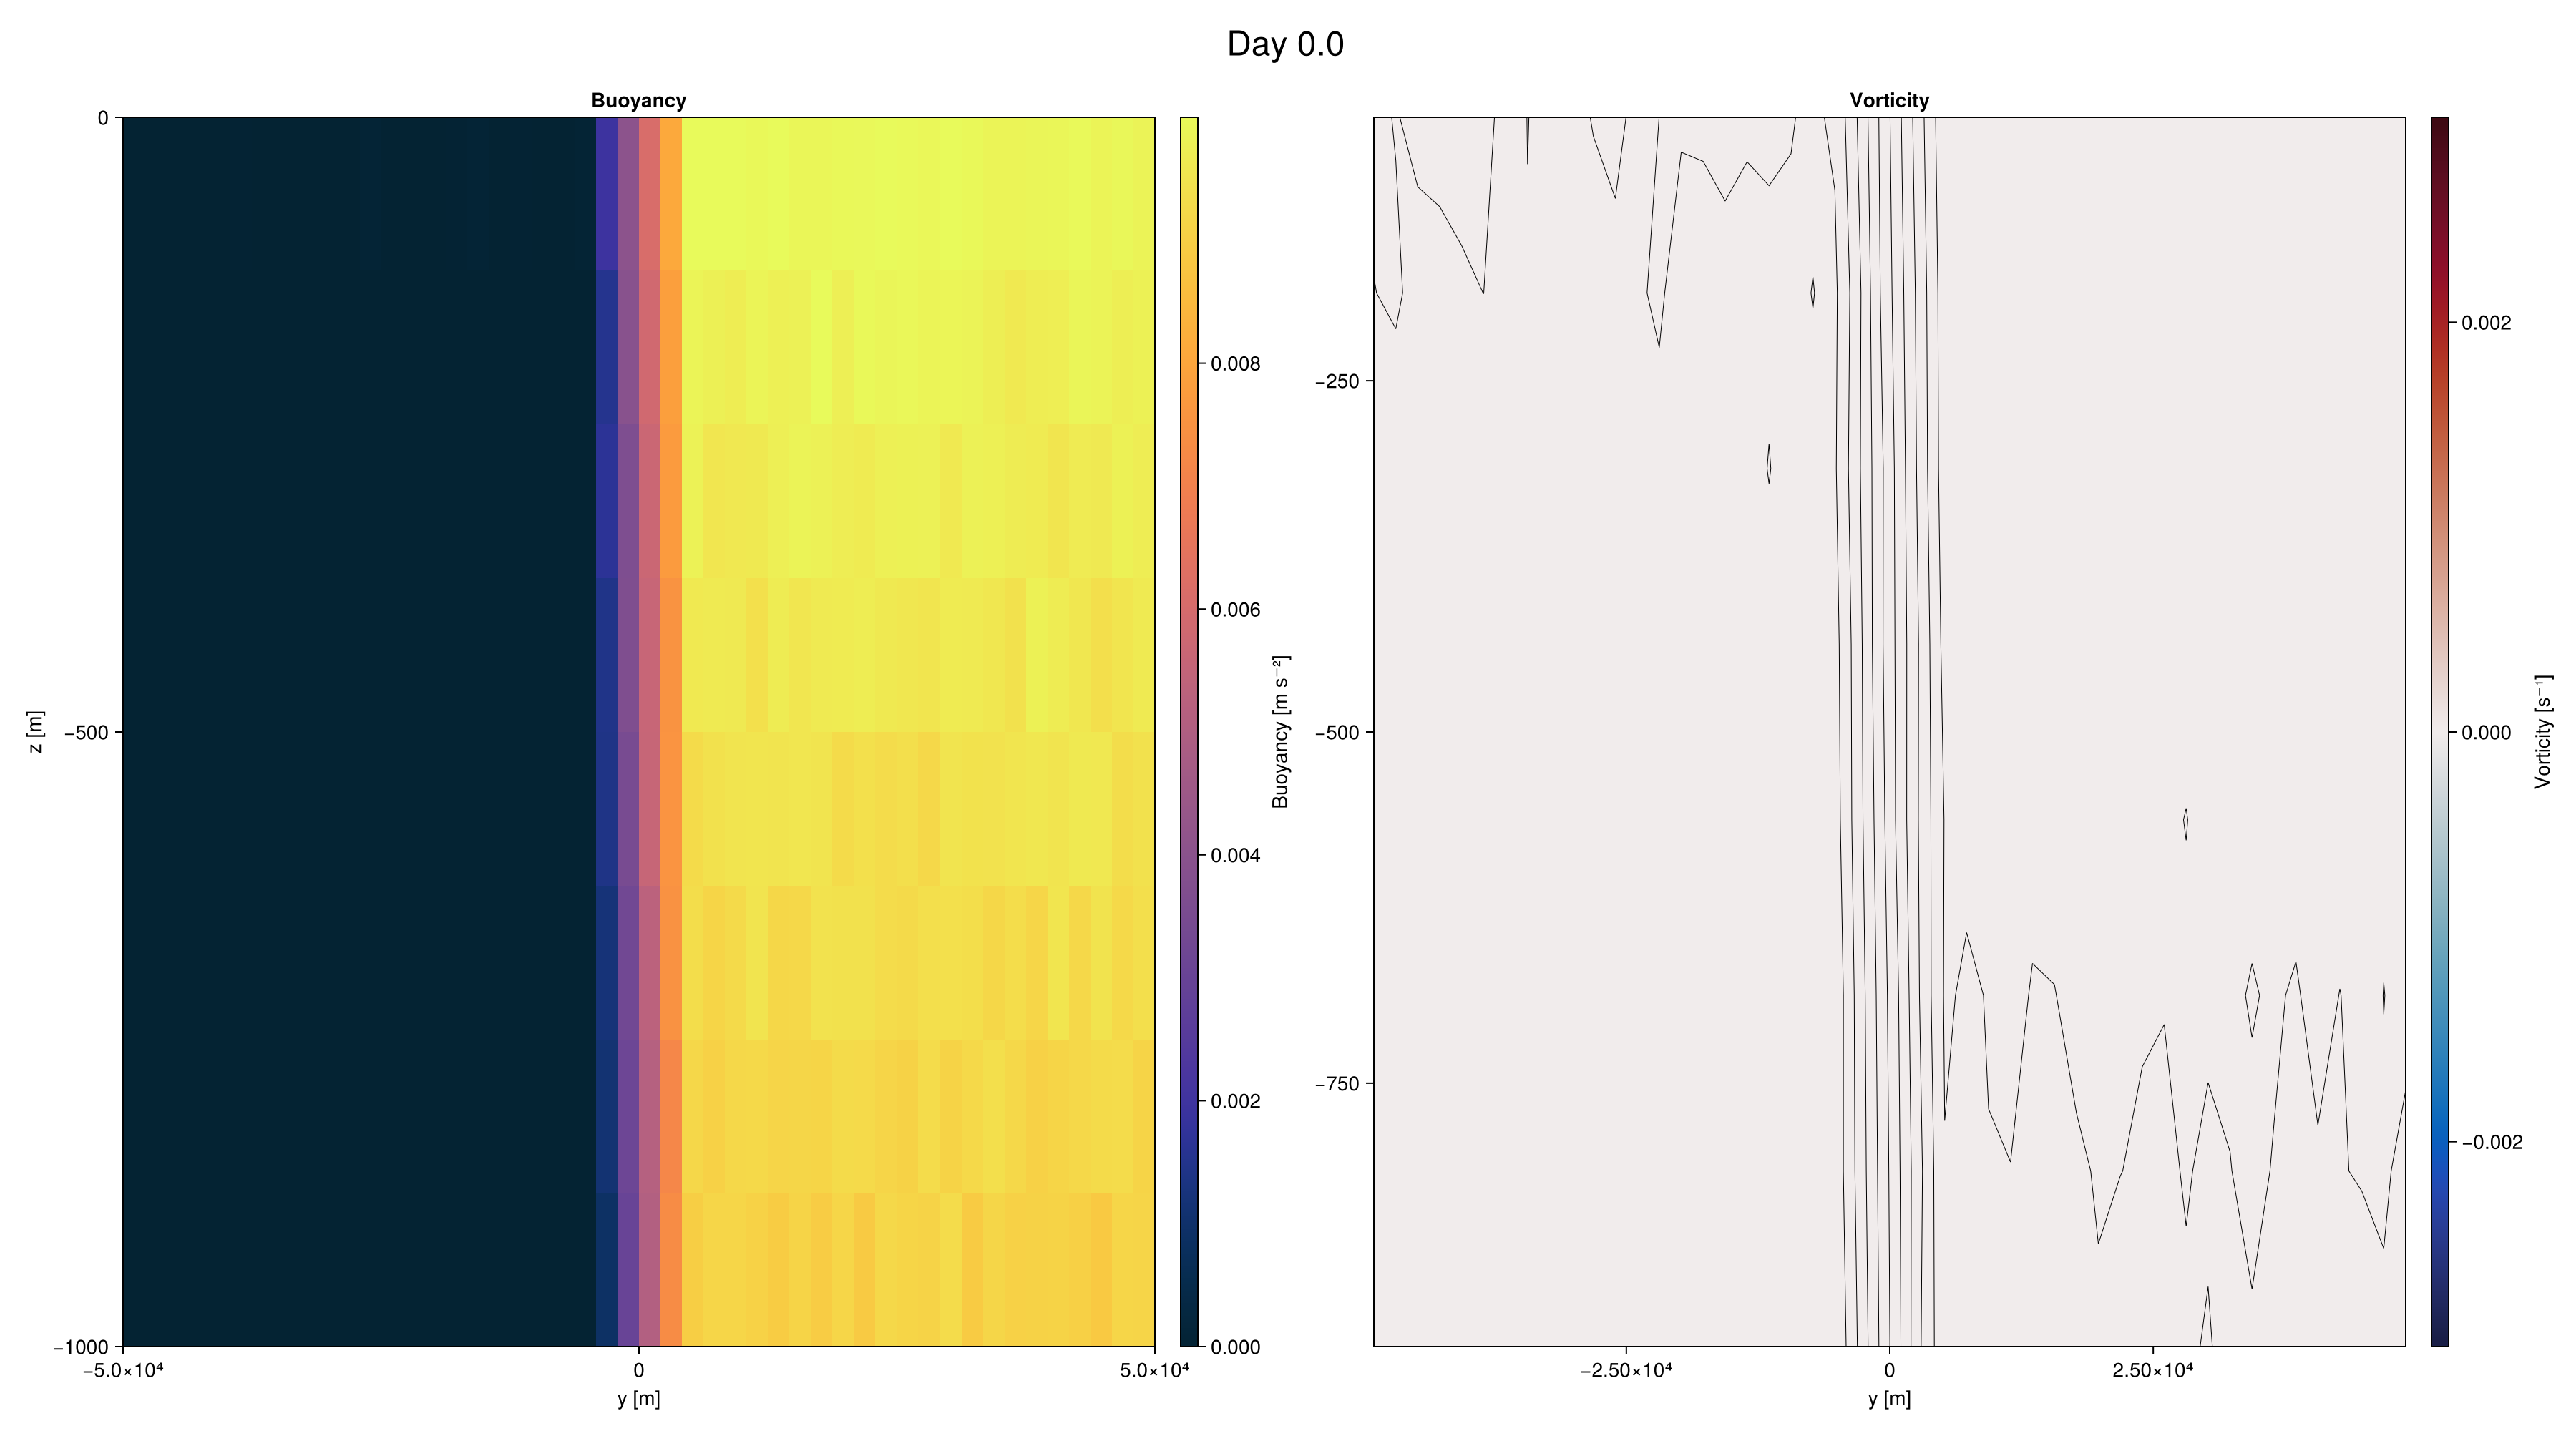

In [55]:


# Animations of Buoyancy and Vorticity
empty!(fig)

# Buoyancy plot
ax_b = Axis(fig[1, 1], title="Buoyancy", xlabel="y [m]", ylabel="z [m]")
hm_b = heatmap!(ax_b, x, z, b_slice, colorrange=(0, Δb), colormap=:thermal)
Colorbar(fig[1, 2], hm_b, label="Buoyancy [m s⁻²]")
#(ax_b, x, z, b_slice ; levels=10, color=:black, linewidth=0.5)


# Vorticity plot
ax_ζ = Axis(fig[1, 3], title="Vorticity", xlabel="y [m]")
hm_ζ = heatmap!(ax_ζ, x, z, ζ_slice, colorrange=(-3e-3, 3e-3), colormap=:balance)
Colorbar(fig[1, 4], hm_ζ, label="Vorticity [s⁻¹]")
contour!(ax_ζ, x, z, b_slice ; levels=10, color=:black, linewidth=0.5)

Label(fig[0, :], title_text, fontsize=24)

# Create animation
frames = 1:length(times)
record(fig, filename * "_animation.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame 


     



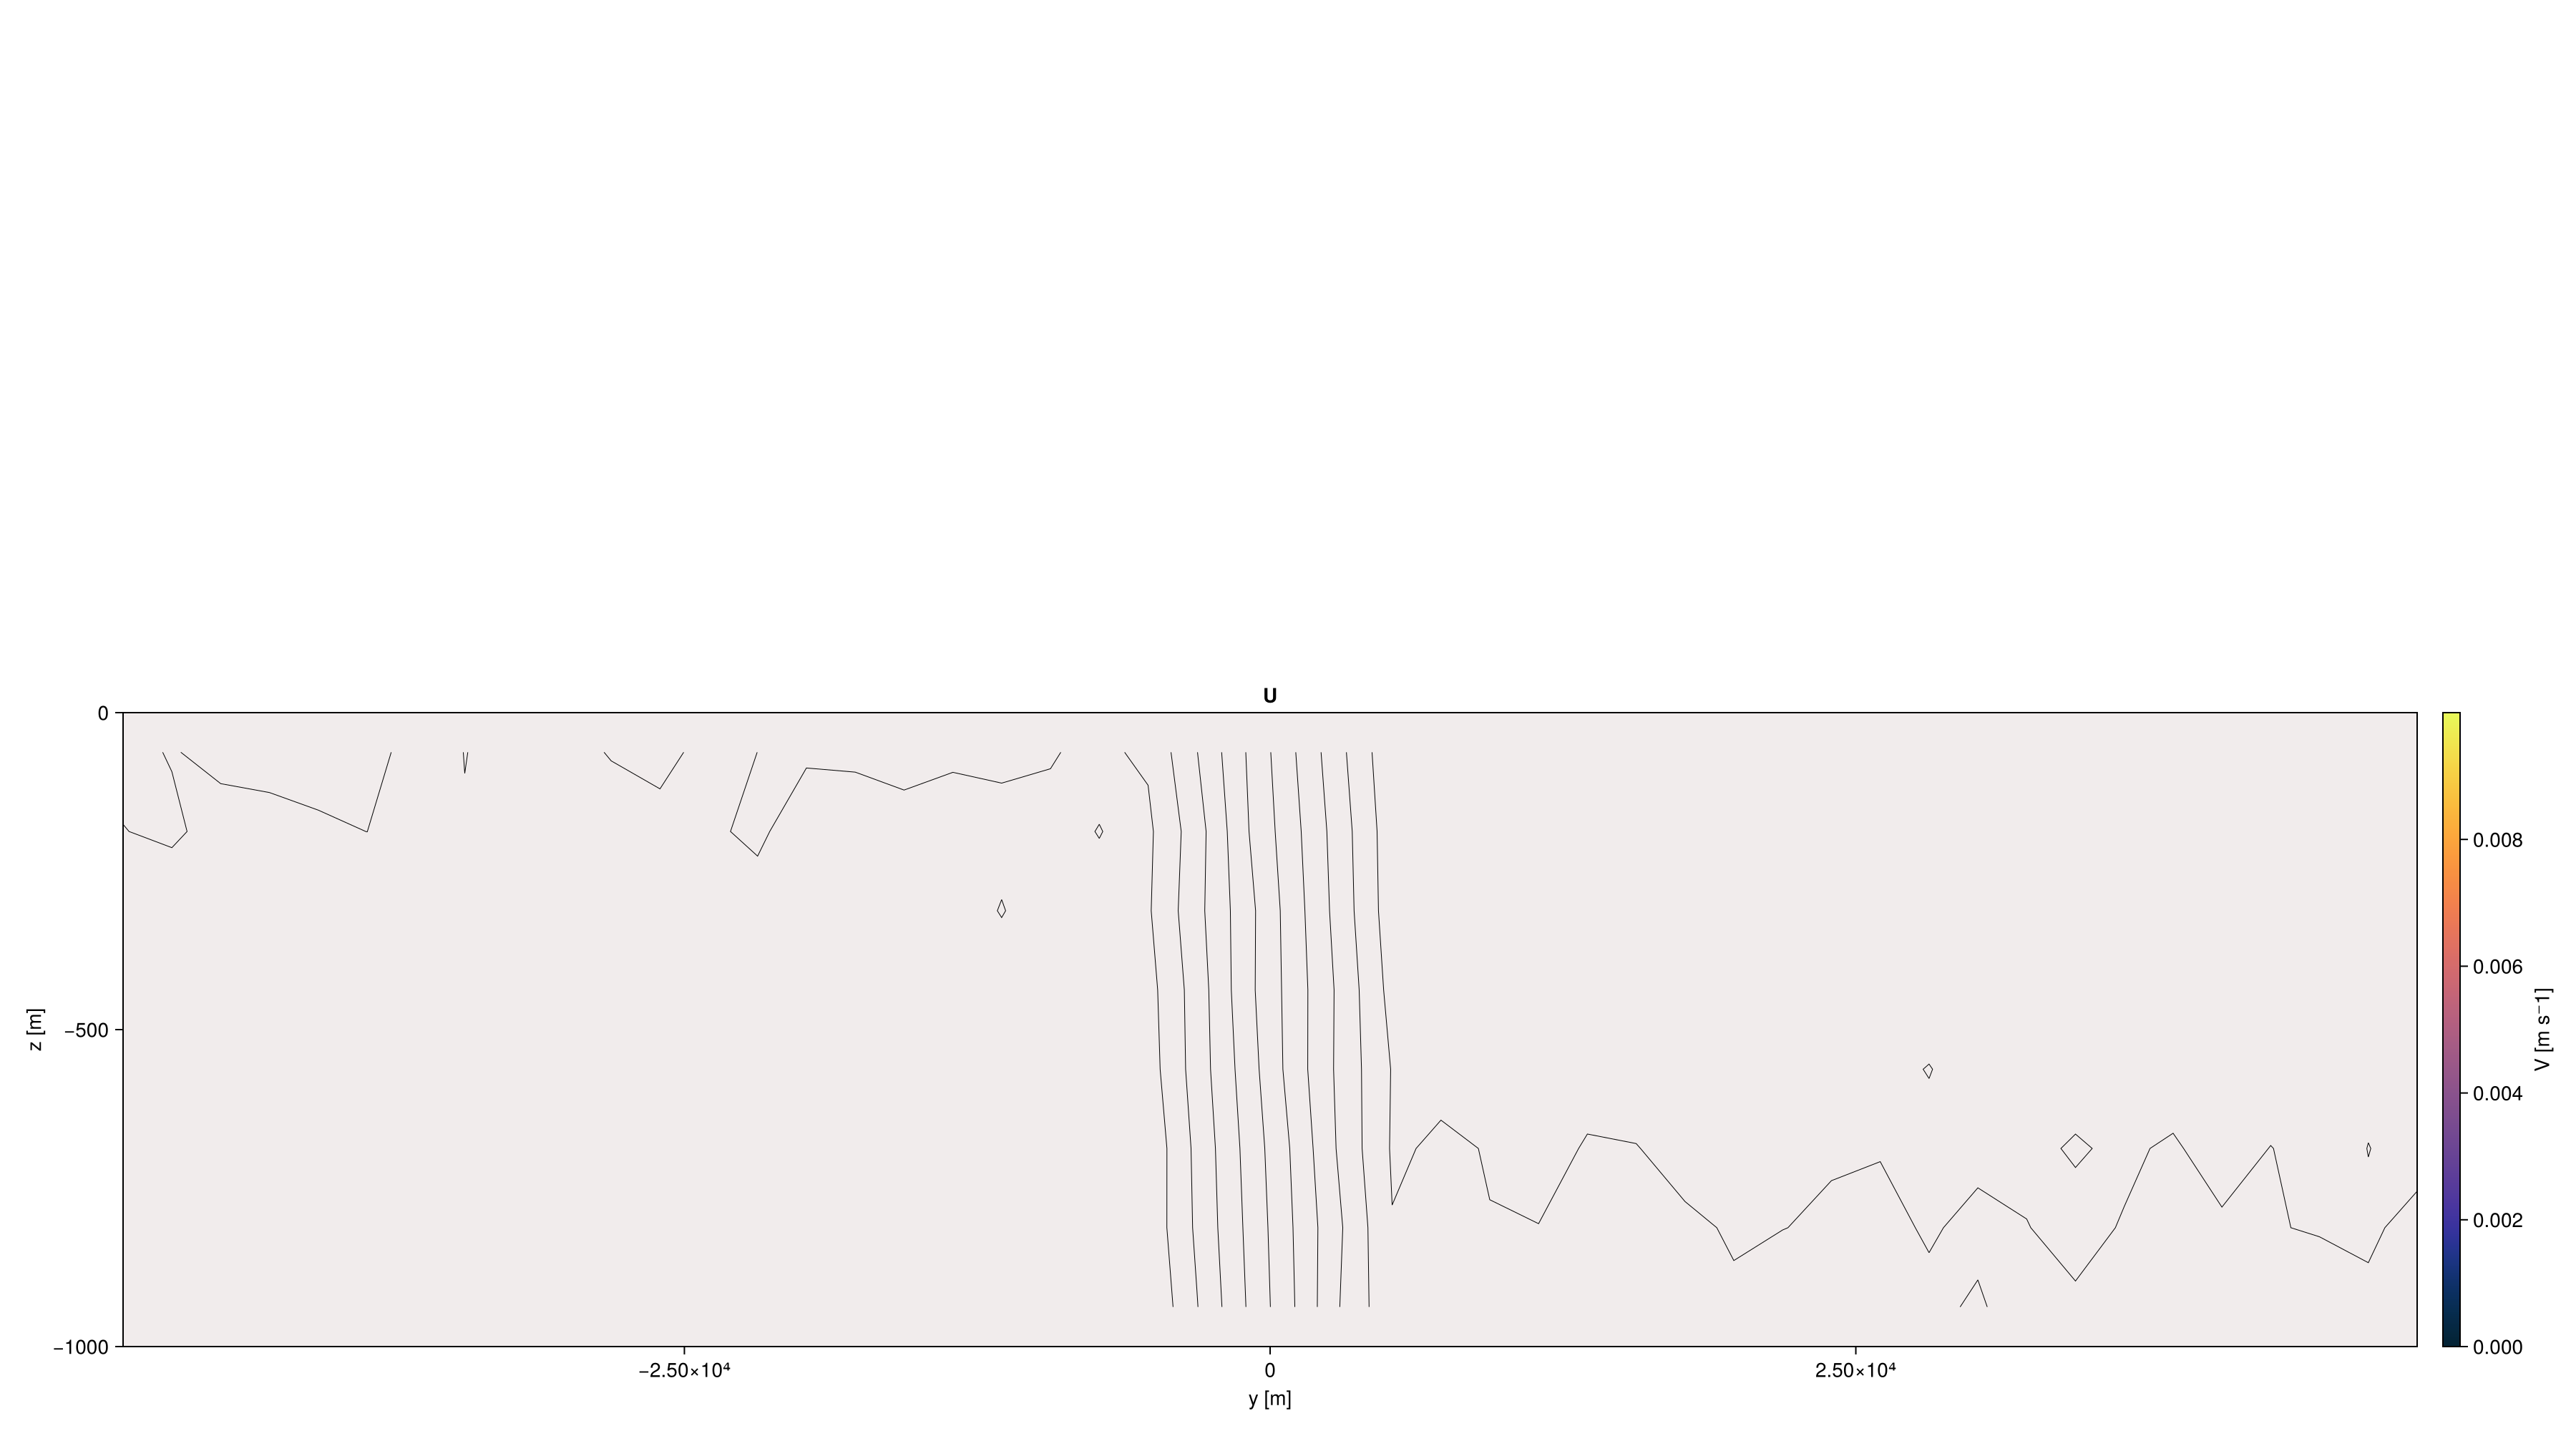

In [53]:
#animation of U only


empty!(fig)

ax_u = Axis(fig[1, 1], title="U", xlabel="y [m]", ylabel="z [m]")
hm = heatmap!(ax_u, x, z, u_slice; colorrange=(-5e-5, 5e-5), colormap=:balance)
Colorbar(fig[1, 2], hm_b, label="V [m s⁻1]")
contour!(ax_u, x, z, b_slice, levels=10, color=:black, linewidth=0.5)


# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame

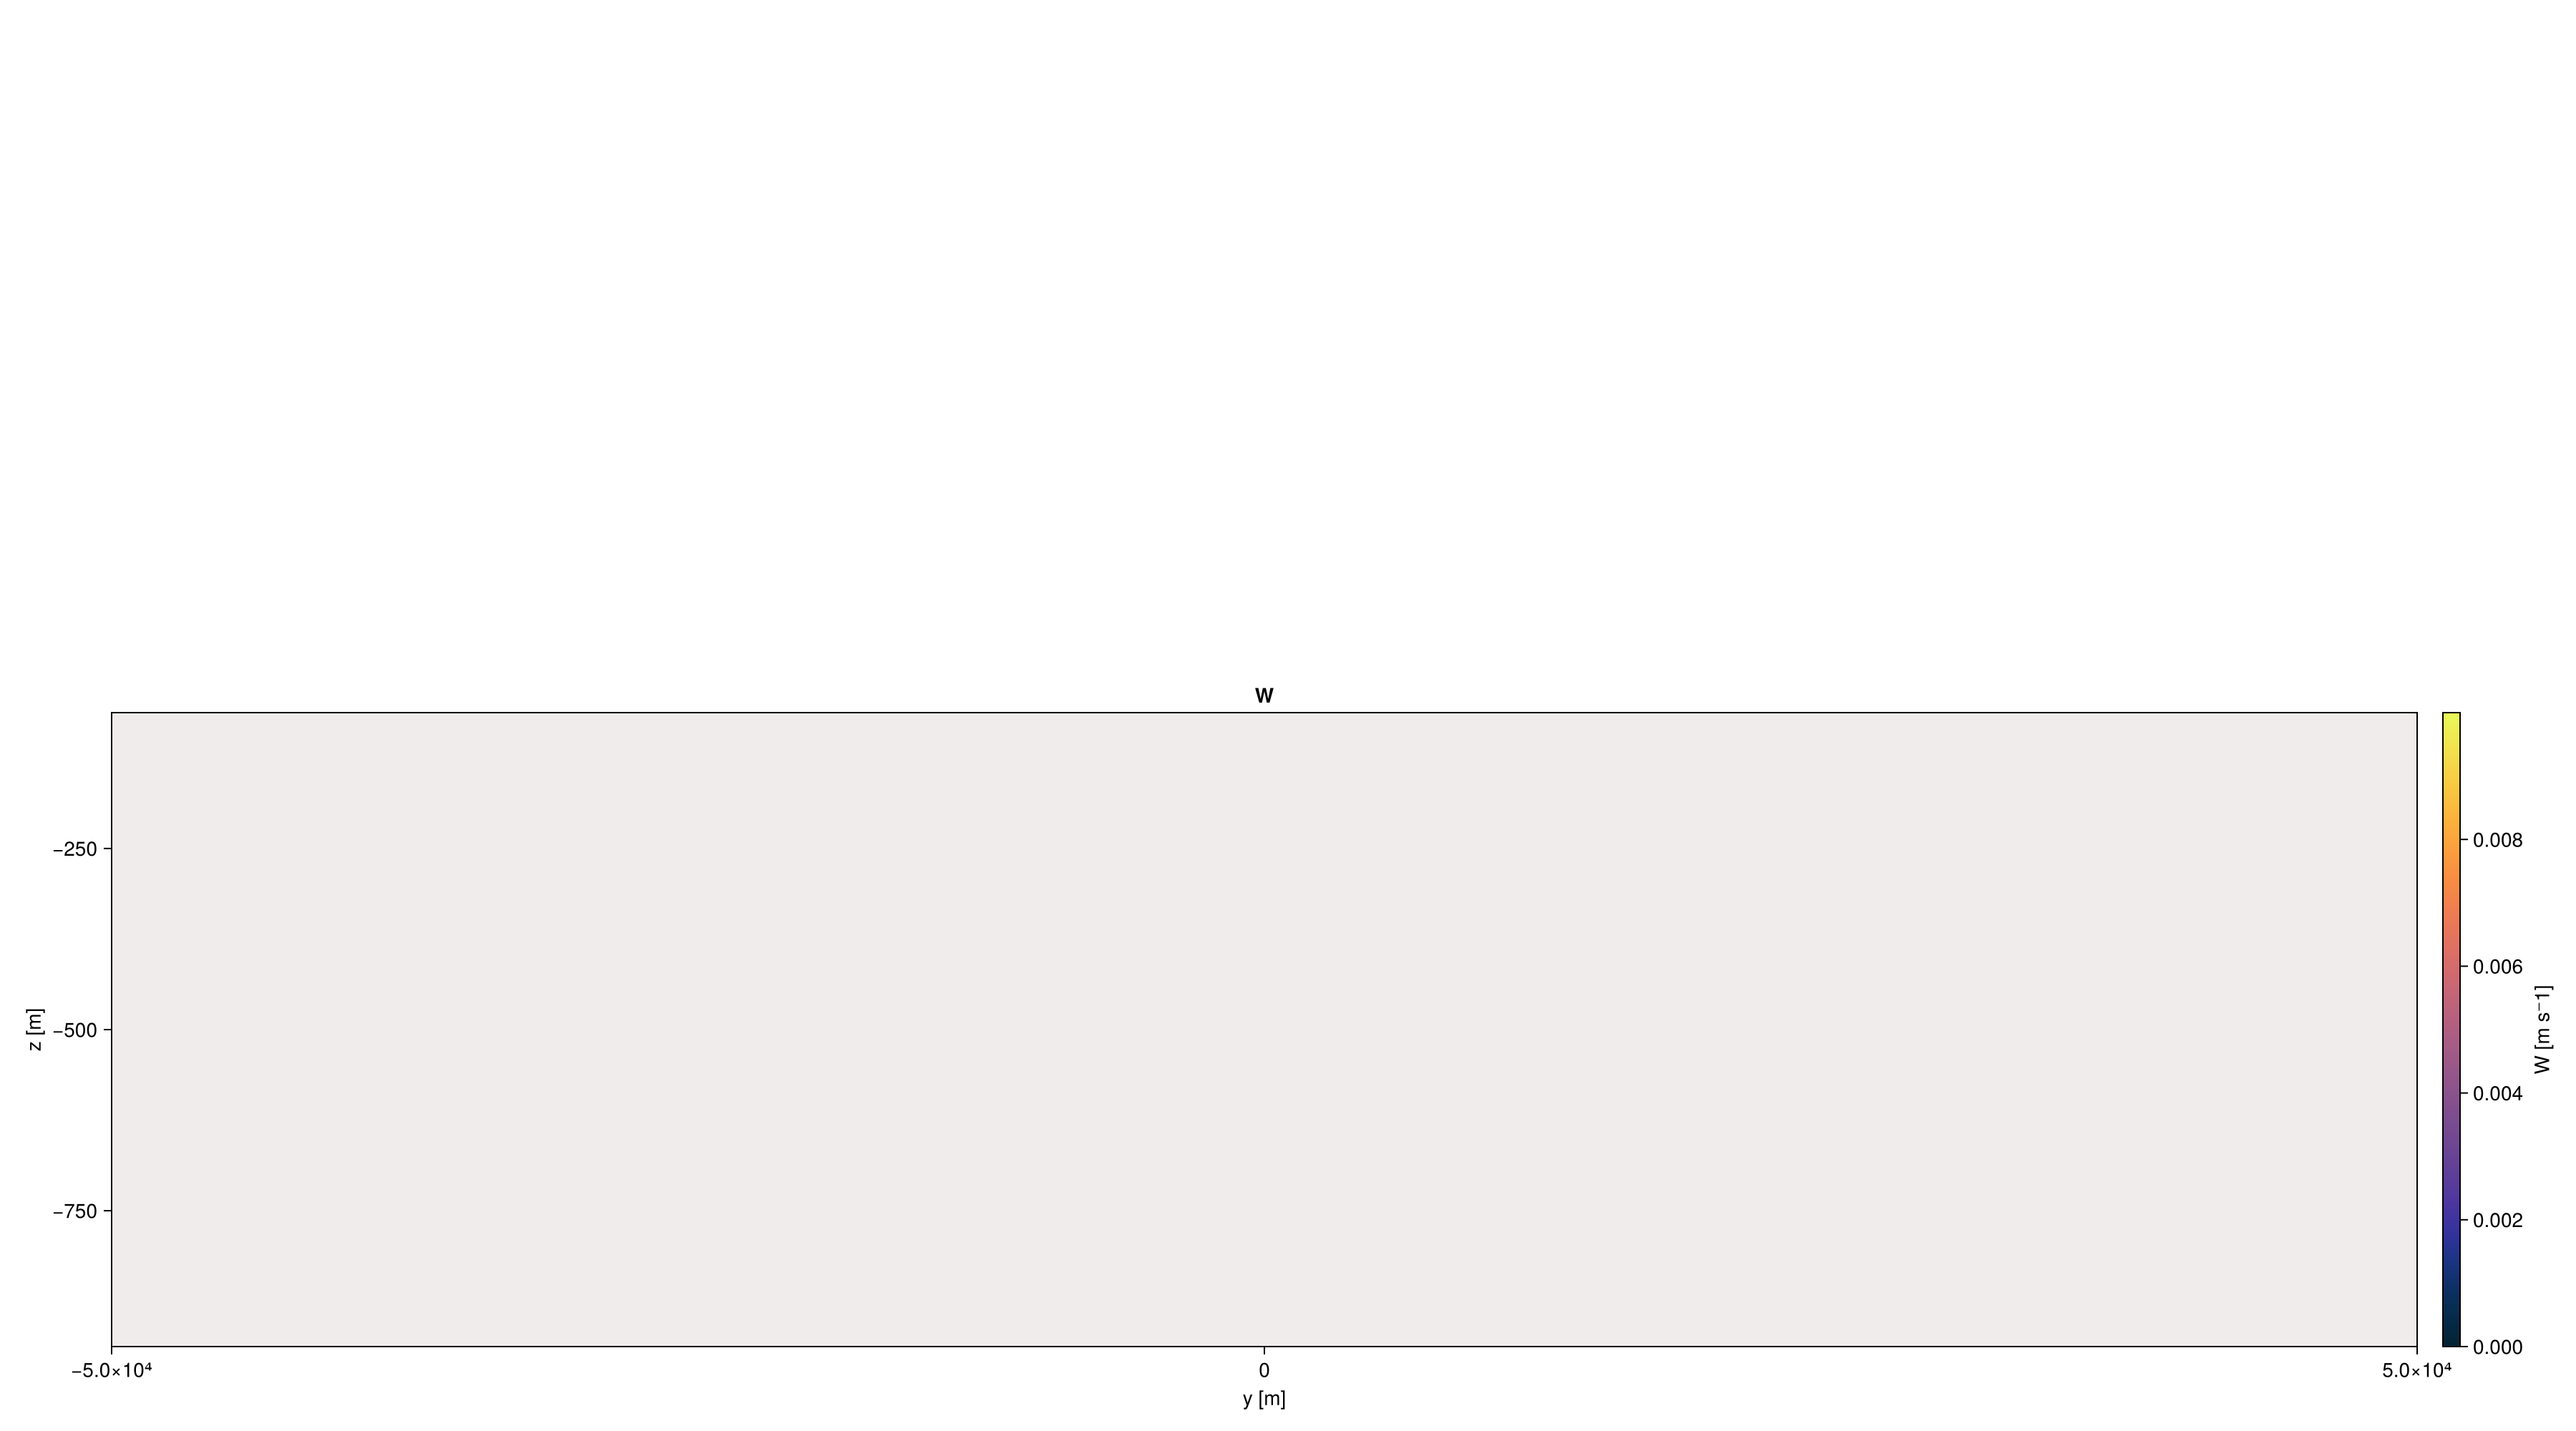

In [54]:
#animation of W only

empty!(fig)

ax_w = Axis(fig[1, 1], title="W", xlabel="y [m]", ylabel="z [m]")
hm = heatmap!(ax_w, x, z, w_slice; colorrange=(-5e-5, 5e-5), colormap=:balance)
Colorbar(fig[1, 2], hm_b, label="W [m s⁻1]")
#contour!(ax_u, x, z, b_slice, levels=10, color=:black, linewidth=0.5)


# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame